In [1]:
from helpers import *

## Data Generation

In [2]:
data_paths = {  'd_ntp'     : '../jupyter-notebooks/ntp_ddos_14_minutes.csv',
                'd_udp'     : '../jupyter-notebooks/udp_ddos_2_minutes.csv',
                'd_syn'     : '../jupyter-notebooks/syn_ddos_3_minutes.csv',
                'd_ldap'    : '../jupyter-notebooks/ldap_ddos_9_minutes.csv',
                'd_udp_lag' : '../jupyter-notebooks/udp_lag_ddos_7_minutes.csv',
             
                'b_ntp'     : '../jupyter-notebooks/ntp_benign_30_minutes.csv',
                'b_syn'     : '../jupyter-notebooks/syn_benign_1_minutes.csv',
                'b_ldap'    : '../jupyter-notebooks/ldap_benign_5_minutes.csv',
                'b_udp_lag' : '../jupyter-notebooks/udp_lag_benign_7_minutes.csv'}

dataset_dict = {}

for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    dataset_dict[data_name] = data


syn_df = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"] , dataset_dict["d_syn"],
                    dataset_dict["d_syn"], dataset_dict["b_udp_lag"],
                    dataset_dict["d_syn"], dataset_dict["b_ntp"].iloc[:5*60, :]], axis=0).reset_index(drop=True)

ntp_df = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"] , dataset_dict["d_ntp"][:5*60],
                    dataset_dict["b_udp_lag"],
                    dataset_dict["d_syn"], dataset_dict["b_ntp"].iloc[:5*60, :]], axis=0).reset_index(drop=True)


mixed_attacks = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"],
                        dataset_dict["d_ntp"][:1*60], #DDOS
                        dataset_dict["b_udp_lag"],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_ntp"][:3*60],
                        dataset_dict["d_udp_lag"][:1*60], #DDOS
                        dataset_dict["b_ntp"][:5*60],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_syn"][:1*60],
                        dataset_dict["d_udp"][:1*60], #DDOS
                        dataset_dict["b_udp_lag"][:4*60],
                        dataset_dict["d_ntp"][:1*60], #DDOS,
                        dataset_dict["b_ldap"][:3*60],
                        dataset_dict["d_ldap"][:1*60], #DDOS
                        dataset_dict["b_ldap"], dataset_dict["b_ntp"][:5*60],
                        dataset_dict["d_ntp"][:1*60], #DDOS
                        dataset_dict["b_syn"],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_ldap"], dataset_dict["b_ldap"][:2*60]], axis = 0).reset_index(drop=True)

Dataset is loaded in 0.014582825126126409 seconds
Dataset is loaded in 0.005841702921316028 seconds
Dataset is loaded in 0.00405371910892427 seconds
Dataset is loaded in 0.004194464068859816 seconds
Dataset is loaded in 0.004448386142030358 seconds
Dataset is loaded in 0.009199015097692609 seconds
Dataset is loaded in 0.002920473925769329 seconds
Dataset is loaded in 0.0034483049530535936 seconds
Dataset is loaded in 0.005023487843573093 seconds


## Plotting Attacks

Total Duration Of Traffic is: 31.0 minutes


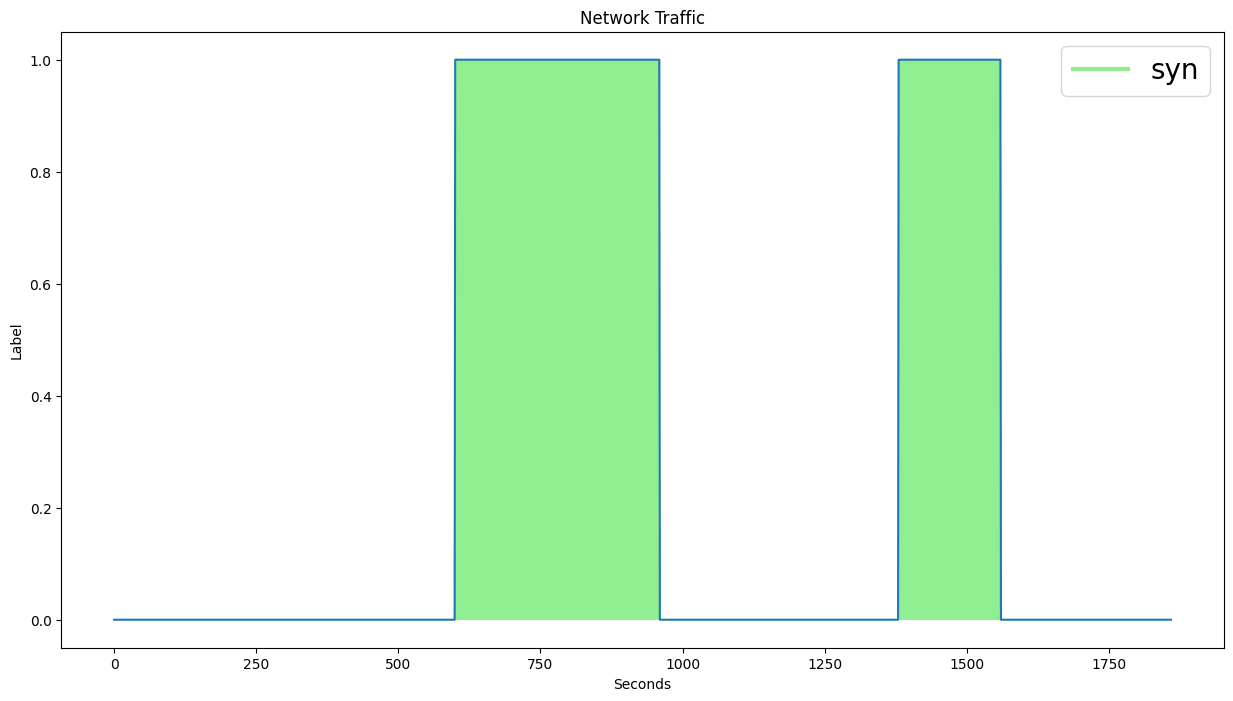

In [3]:
plot_ddos(syn_df, attack_list=[('syn', 6, 10), ('syn', 3, 23)])

Total Duration Of Traffic is: 30.0 minutes


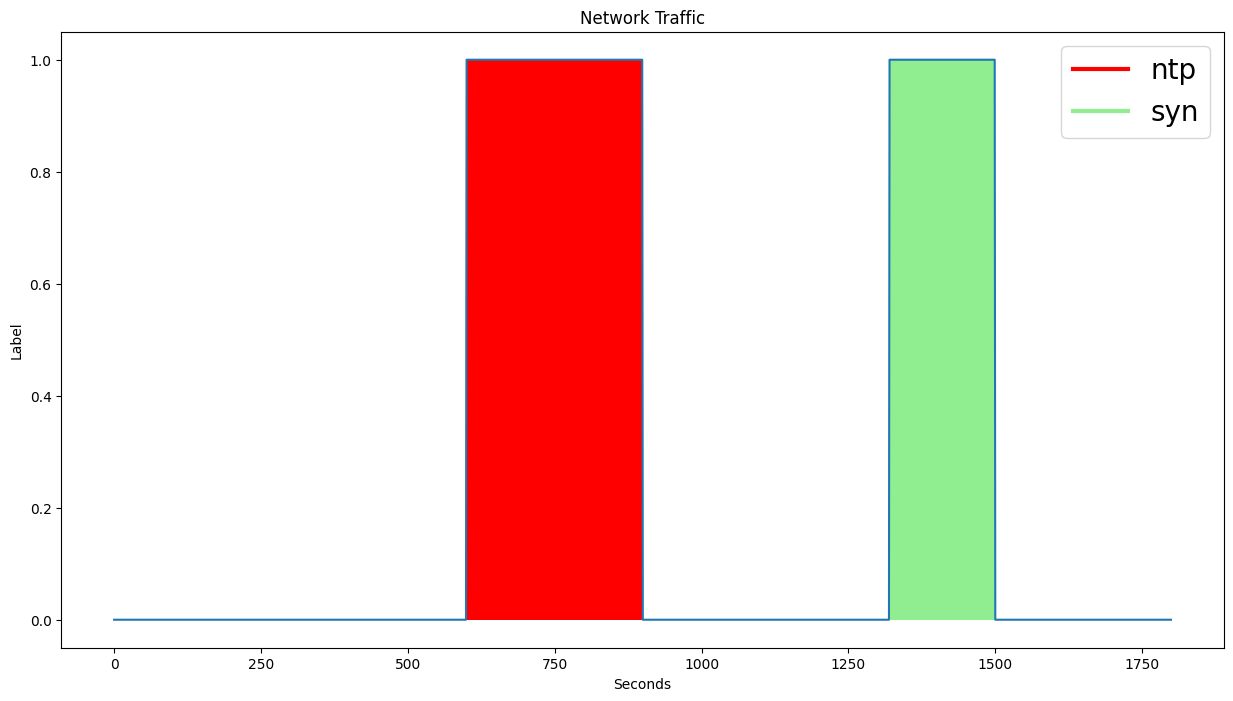

In [4]:
plot_ddos(ntp_df, attack_list=[('ntp', 5, 10), ('syn', 3, 22)])

Total Duration Of Traffic is: 60.0 minutes


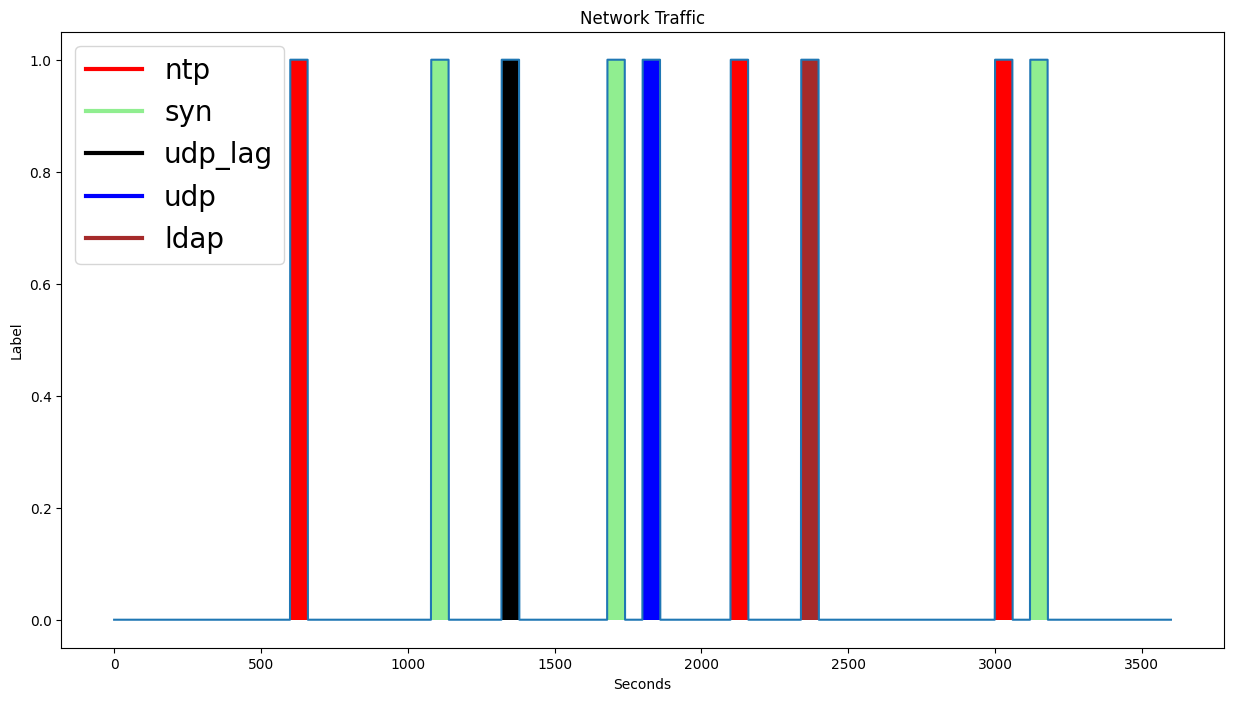

In [5]:
plot_ddos(mixed_attacks, [('ntp', 1, 10), ('syn', 1, 18),
                         ('udp_lag', 1, 22), ('syn', 1, 28),
                         ('udp', 1, 30), ('ntp', 1, 35),
                         ('ldap', 1, 39), ('ntp', 1, 50), ('syn', 1, 52)])

## Calculate Matrix Profile Results Threshold Base

In [6]:
window_sizes = [5, 10, 20]
thresholds = {"0.5": 0.5, "1":1.0, "1.5":1.5, "2":2.0}
simulation_datasets = {"syn_df": syn_df, "ntp_syn": ntp_df, "mixed_df": mixed_attacks}

In [7]:
import warnings
warnings.filterwarnings('ignore')

final_results = {}
counter: int = 0
for df_name, dataframe in simulation_datasets.items():
    final_results[df_name] = {"accuracy": [], "f1-score":[]}
    for window_size in window_sizes:
        for threshold in thresholds.values():
            counter += 1
            print(f"Processing {df_name} : {window_size} : {threshold} : %{(counter * 100)/(len(window_sizes) * len(thresholds) * len(simulation_datasets.keys()))}")
            #initialize necessary items for calculations
            accuracy_list, f1_score_list, mp_label_df = [], [], pd.DataFrame({"W_Label": [], "mp_scores": []})
            df = dataframe.copy()
            mp_label_df["W_Label"] = calculate_matrix_profile_window_labels(df, windowSize=window_size, labelIdx=-1)

            for feature in df.columns[1:-1]:
                mp_res = calculate_matrix_profile(df, feature, window_size)
                mp_label_df["mp_scores"] = mp_res["mp"]
                results = matrix_profile_threshold_predictions(mp_label_df, mp_threshold=threshold, verbose=False)

                accuracy_list.append((feature, results["accuracy"]))
                f1_score_list.append((feature, results['macro avg']["f1-score"]))
                mp_label_df["mp_scores"] = 0

            final_results[df_name]["accuracy"].append((sorted(accuracy_list, key=lambda x:x[1], reverse=True)[0], f"th_{threshold}_w_{window_size}"))
            final_results[df_name]["f1-score"].append((sorted(f1_score_list, key=lambda x:x[1], reverse=True)[0], f"th_{threshold}_w_{window_size}"))

Processing syn_df : 5 : 0.5 : %2.7777777777777777
Processing syn_df : 5 : 1.0 : %5.555555555555555
Processing syn_df : 5 : 1.5 : %8.333333333333334
Processing syn_df : 5 : 2.0 : %11.11111111111111
Processing syn_df : 10 : 0.5 : %13.88888888888889
Processing syn_df : 10 : 1.0 : %16.666666666666668
Processing syn_df : 10 : 1.5 : %19.444444444444443
Processing syn_df : 10 : 2.0 : %22.22222222222222
Processing syn_df : 20 : 0.5 : %25.0
Processing syn_df : 20 : 1.0 : %27.77777777777778
Processing syn_df : 20 : 1.5 : %30.555555555555557
Processing syn_df : 20 : 2.0 : %33.333333333333336
Processing ntp_syn : 5 : 0.5 : %36.111111111111114
Processing ntp_syn : 5 : 1.0 : %38.888888888888886
Processing ntp_syn : 5 : 1.5 : %41.666666666666664
Processing ntp_syn : 5 : 2.0 : %44.44444444444444
Processing ntp_syn : 10 : 0.5 : %47.22222222222222
Processing ntp_syn : 10 : 1.0 : %50.0
Processing ntp_syn : 10 : 1.5 : %52.77777777777778
Processing ntp_syn : 10 : 2.0 : %55.55555555555556
Processing ntp_syn

In [8]:
for df_name in simulation_datasets:
    print(f"Best Results For {df_name.upper()}\nACCURACY:  {sorted(final_results[f'{df_name}']['accuracy'], key=lambda x:x[0][1], reverse=True)[:1]}")
    print(f"F1-SCORE:  {sorted(final_results[f'{df_name}']['f1-score'], key=lambda x:x[0][1], reverse=True)[:1]}")

Best Results For SYN_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.9421934089681253), 'th_2.0_w_10')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.934119283623674), 'th_2.0_w_10')]
Best Results For NTP_SYN
ACCURACY:  [((' Bwd Packet Length Min', 0.9006141820212172), 'th_2.0_w_10')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.877424985773827), 'th_2.0_w_10')]
Best Results For MIXED_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.9058758006126427), 'th_2.0_w_10')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.8461866971347003), 'th_2.0_w_10')]


## Calculate Matrix Profile Results with Percentile Usage

In [9]:
percentile_ranges = [70, 75, 80, 85, 90]
window_sizes = [5, 10, 20]
simulation_datasets = {"syn_df": syn_df, "ntp_syn": ntp_df, "mixed_df": mixed_attacks}

In [10]:
import warnings
warnings.filterwarnings('ignore')

final_results = {}
counter: int = 0
for df_name, dataframe in simulation_datasets.items():
    for window_size in window_sizes:
        final_results[df_name] = {"accuracy" : [], "f1-score": []}
        for percentile in percentile_ranges:
            counter += 1
            print(f"Processing {df_name} : {percentile} : %{(counter * 100)/(len(percentile_ranges) * len(window_sizes) * len(simulation_datasets.keys()))}")
            #initialize necessary items for calculations
            accuracy_list, f1_score_list, mp_label_df = [], [], pd.DataFrame({"W_Label": [], "mp_scores": []})
            df = dataframe.copy()
            mp_label_df["W_Label"] = calculate_matrix_profile_window_labels(df, windowSize=window_size, labelIdx=-1)

            for feature in df.columns[1:-1]:
                mp_res = calculate_matrix_profile(df, feature, window_size)
                mp_label_df["mp_scores"] = mp_res["mp"]
                results = matrix_profile_threshold_predictions(mp_label_df, mp_threshold_percentile=percentile, verbose=False)

                accuracy_list.append((feature, results["accuracy"]))
                f1_score_list.append((feature, results['macro avg']["f1-score"]))
                mp_label_df["mp_scores"] = 0

            final_results[df_name]["accuracy"].append((sorted(accuracy_list, key=lambda x:x[1], reverse=True)[0], f"percentile_{percentile}_w_{window_size}"))
            final_results[df_name]["f1-score"].append((sorted(f1_score_list, key=lambda x:x[1], reverse=True)[0], f"percentile_{percentile}_w_{window_size}"))

Processing syn_df : 70 : %2.2222222222222223
Processing syn_df : 75 : %4.444444444444445
Processing syn_df : 80 : %6.666666666666667
Processing syn_df : 85 : %8.88888888888889
Processing syn_df : 90 : %11.11111111111111
Processing syn_df : 70 : %13.333333333333334
Processing syn_df : 75 : %15.555555555555555
Processing syn_df : 80 : %17.77777777777778
Processing syn_df : 85 : %20.0
Processing syn_df : 90 : %22.22222222222222
Processing syn_df : 70 : %24.444444444444443
Processing syn_df : 75 : %26.666666666666668
Processing syn_df : 80 : %28.88888888888889
Processing syn_df : 85 : %31.11111111111111
Processing syn_df : 90 : %33.333333333333336
Processing ntp_syn : 70 : %35.55555555555556
Processing ntp_syn : 75 : %37.77777777777778
Processing ntp_syn : 80 : %40.0
Processing ntp_syn : 85 : %42.22222222222222
Processing ntp_syn : 90 : %44.44444444444444
Processing ntp_syn : 70 : %46.666666666666664
Processing ntp_syn : 75 : %48.888888888888886
Processing ntp_syn : 80 : %51.11111111111111

In [11]:
for df_name in simulation_datasets:
    print(f"Best Results For {df_name.upper()}\nACCURACY:  {sorted(final_results[f'{df_name}']['accuracy'], key=lambda x:x[0][1], reverse=True)[:1]}")
    print(f"F1-SCORE:  {sorted(final_results[f'{df_name}']['f1-score'], key=lambda x:x[0][1], reverse=True)[:1]}")

Best Results For SYN_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.9641499185225421), 'percentile_70_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.9578654256942325), 'percentile_70_w_20')]
Best Results For NTP_SYN
ACCURACY:  [((' Flow IAT Min', 0.8871420550252667), 'percentile_75_w_20')]
F1-SCORE:  [((' Flow IAT Min', 0.8610553981791467), 'percentile_70_w_20')]
Best Results For MIXED_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.8927673834124547), 'percentile_85_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.8136885096641606), 'percentile_85_w_20')]


## Calculate Matrix Profile Results with IQR Score

In [12]:
iqr_coefficients = [1.0, 1.25, 1.5, 1,75, 2.0, 3.0, 5.0, 10.0]
window_sizes = [5, 10, 20]
simulation_datasets = {"syn_df": syn_df, "ntp_syn": ntp_df, "mixed_df": mixed_attacks}

In [13]:
import warnings
warnings.filterwarnings('ignore')

final_results = {}
counter: int = 0
for df_name, dataframe in simulation_datasets.items():
    for window_size in window_sizes:
        final_results[df_name] = {"accuracy" : [], "f1-score": []}
        for iqr_coeff in iqr_coefficients:
            counter += 1
            print(f"Processing {df_name} : {iqr_coeff} : %{(counter * 100)/(len(iqr_coefficients) * len(window_sizes) * len(simulation_datasets.keys()))}")
            #initialize necessary items for calculations
            accuracy_list, f1_score_list, mp_label_df = [], [], pd.DataFrame({"W_Label": [], "mp_scores": []})
            df = dataframe.copy()
            mp_label_df["W_Label"] = calculate_matrix_profile_window_labels(df, windowSize=window_size, labelIdx=-1)

            for feature in df.columns[1:-1]:
                mp_res = calculate_matrix_profile(df, feature, window_size)
                mp_label_df["mp_scores"] = mp_res["mp"]
                results = matrix_profile_threshold_predictions(mp_label_df, iqr_coefficient=iqr_coeff, verbose=False)

                accuracy_list.append((feature, results["accuracy"]))
                f1_score_list.append((feature, results['macro avg']["f1-score"]))
                mp_label_df["mp_scores"] = 0

            final_results[df_name]["accuracy"].append((sorted(accuracy_list, key=lambda x:x[1], reverse=True)[0], f"iqr_{iqr_coeff}_w_{window_size}"))
            final_results[df_name]["f1-score"].append((sorted(f1_score_list, key=lambda x:x[1], reverse=True)[0], f"iqr_{iqr_coeff}_w_{window_size}"))

Processing syn_df : 1.0 : %1.2345679012345678
Processing syn_df : 1.25 : %2.4691358024691357
Processing syn_df : 1.5 : %3.7037037037037037
Processing syn_df : 1 : %4.938271604938271
Processing syn_df : 75 : %6.172839506172839
Processing syn_df : 2.0 : %7.407407407407407
Processing syn_df : 3.0 : %8.641975308641975
Processing syn_df : 5.0 : %9.876543209876543
Processing syn_df : 10.0 : %11.11111111111111
Processing syn_df : 1.0 : %12.345679012345679
Processing syn_df : 1.25 : %13.580246913580247
Processing syn_df : 1.5 : %14.814814814814815
Processing syn_df : 1 : %16.049382716049383
Processing syn_df : 75 : %17.28395061728395
Processing syn_df : 2.0 : %18.51851851851852
Processing syn_df : 3.0 : %19.753086419753085
Processing syn_df : 5.0 : %20.987654320987655
Processing syn_df : 10.0 : %22.22222222222222
Processing syn_df : 1.0 : %23.45679012345679
Processing syn_df : 1.25 : %24.691358024691358
Processing syn_df : 1.5 : %25.925925925925927
Processing syn_df : 1 : %27.160493827160494
P

In [14]:
for df_name in simulation_datasets:
    print(f"Best Results For {df_name.upper()}\nACCURACY:  {sorted(final_results[f'{df_name}']['accuracy'], key=lambda x:x[0][1], reverse=True)[:1]}")
    print(f"F1-SCORE:  {sorted(final_results[f'{df_name}']['f1-score'], key=lambda x:x[0][1], reverse=True)[:1]}")

Best Results For SYN_DF
ACCURACY:  [(('Bwd Packet Length Max', 0.7278652906029331), 'iqr_2.0_w_20')]
F1-SCORE:  [(('Bwd Packet Length Max', 0.5434816502431967), 'iqr_2.0_w_20')]
Best Results For NTP_SYN
ACCURACY:  [((' Bwd Packet Length Min', 0.8994946659180236), 'iqr_1.0_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.864614215127328), 'iqr_1.0_w_20')]
Best Results For MIXED_DF
ACCURACY:  [((' Fwd Header Length', 0.8829935772130689), 'iqr_1.0_w_20')]
F1-SCORE:  [((' Fwd Packet Length Max', 0.805306751468194), 'iqr_2.0_w_20')]


## Calculate Matrix Profile Results w Isolation Forest

In [15]:
n_estimators = [50, 100, 200]
contaminations = ["auto", 0.1, 0.2]
window_sizes = [5, 10, 20]
simulation_datasets = {"syn_df": syn_df, "ntp_syn": ntp_df, "mixed_df": mixed_attacks}

In [16]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

final_results = {}
counter: int = 0
for df_name, dataframe in simulation_datasets.items():
    for window_size in window_sizes:
        final_results[df_name] = {"accuracy" : [], "f1-score": []}
        for estimator in n_estimators:
            for contamination in contaminations:
                counter += 1
                print(f"Processing {df_name} : nest_{estimator} : c_{contamination} : %{(counter * 100)/(len(n_estimators) * len(contaminations) * len(window_sizes) * len(simulation_datasets.keys()))}")
                accuracy_list, f1_score_list = [], []
                df = dataframe.copy()

                for feature in df.columns[1:-1]:
                    mp_label_df = pd.DataFrame({"mp_scores": []})
                    mp_res = calculate_matrix_profile(df, feature, window_size)
                    mp_label_df["mp_scores"] = mp_res["mp"]
                    mp_label_df = isolation_forest_predictions(mp_label_df, n_est=estimator, cont=contamination)
                    mp_label_df["Preds"] = mp_label_df["anomaly"].apply(lambda x: 1 if x == -1 else 0)
                    mp_label_df["W_Label"] = calculate_matrix_profile_window_labels(df, windowSize=window_size, labelIdx=-1)

                    results = classification_report(mp_label_df["W_Label"], mp_label_df["Preds"], output_dict=True)


                    accuracy_list.append((feature, results["accuracy"]))
                    f1_score_list.append((feature, results['macro avg']["f1-score"]))
                    del mp_label_df

                final_results[df_name]["accuracy"].append((sorted(accuracy_list, key=lambda x:x[1], reverse=True)[0], f"nest_{estimator}_cont_{contamination}_w_{window_size}"))
                final_results[df_name]["f1-score"].append((sorted(f1_score_list, key=lambda x:x[1], reverse=True)[0], f"nest_{estimator}_cont_{contamination}_w_{window_size}"))

Processing syn_df : nest_50 : c_auto : %1.2345679012345678
Processing syn_df : nest_50 : c_0.1 : %2.4691358024691357
Processing syn_df : nest_50 : c_0.2 : %3.7037037037037037
Processing syn_df : nest_100 : c_auto : %4.938271604938271
Processing syn_df : nest_100 : c_0.1 : %6.172839506172839
Processing syn_df : nest_100 : c_0.2 : %7.407407407407407
Processing syn_df : nest_200 : c_auto : %8.641975308641975
Processing syn_df : nest_200 : c_0.1 : %9.876543209876543
Processing syn_df : nest_200 : c_0.2 : %11.11111111111111
Processing syn_df : nest_50 : c_auto : %12.345679012345679
Processing syn_df : nest_50 : c_0.1 : %13.580246913580247
Processing syn_df : nest_50 : c_0.2 : %14.814814814814815
Processing syn_df : nest_100 : c_auto : %16.049382716049383
Processing syn_df : nest_100 : c_0.1 : %17.28395061728395
Processing syn_df : nest_100 : c_0.2 : %18.51851851851852
Processing syn_df : nest_200 : c_auto : %19.753086419753085
Processing syn_df : nest_200 : c_0.1 : %20.987654320987655
Proce

In [17]:
for df_name in simulation_datasets:
    print(f"Best Results For {df_name.upper()}\nACCURACY:  {sorted(final_results[f'{df_name}']['accuracy'], key=lambda x:x[0][1], reverse=True)[:1]}")
    print(f"F1-SCORE:  {sorted(final_results[f'{df_name}']['f1-score'], key=lambda x:x[0][1], reverse=True)[:1]}")

Best Results For SYN_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.7311243889190657), 'nest_100_cont_auto_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.7270104741919685), 'nest_100_cont_auto_w_20')]
Best Results For NTP_SYN
ACCURACY:  [((' Fwd Header Length', 0.8680516563728242), 'nest_50_cont_auto_w_20')]
F1-SCORE:  [((' Fwd Header Length', 0.8110858293721849), 'nest_50_cont_auto_w_20')]
Best Results For MIXED_DF
ACCURACY:  [((' Fwd Header Length', 0.8829935772130689), 'nest_50_cont_0.1_w_20')]
F1-SCORE:  [((' Fwd Packet Length Max', 0.8004854408758018), 'nest_200_cont_0.2_w_20')]


## Calculate LMOM Anomalies

In [18]:
skew_thresholds = [10, 15, 20]
kurtosis_thresholds = [10, 15, 20]
window_sizes = [5, 10, 20]
simulation_datasets = {"syn_df": syn_df, "ntp_syn": ntp_df, "mixed_df": mixed_attacks}

In [19]:
import warnings
warnings.filterwarnings('ignore')

final_results = {}
counter: int = 0
for df_name, dataframe in simulation_datasets.items():
    for window_size in window_sizes:
        final_results[df_name] = {"accuracy" : [], "f1-score": []}
        for skew_th in skew_thresholds:
            for kurtosis_th in kurtosis_thresholds:
                counter += 1
                print(f"Processing {df_name} : {window_size}:{skew_th}:{kurtosis_th} : %{(counter * 100)/(len(skew_thresholds) * len(kurtosis_thresholds) * len(window_sizes) * len(simulation_datasets.keys()))}")

                accuracy_list, f1_score_list= [], []
                df = dataframe.copy()

                for feature in df.columns[1:-1]:
                    lmom_df = calculate_lmom_df(df, feature, window_size)
                    results = lmom_predictions(lmom_df, skew_th, kurtosis_th)

                    accuracy_list.append((feature, results["accuracy"]))
                    f1_score_list.append((feature, results['macro avg']["f1-score"]))

                final_results[df_name]["accuracy"].append((sorted(accuracy_list, key=lambda x:x[1], reverse=True)[0], f"sk_{skew_th}_kurth_{kurtosis_th}_w_{window_size}"))
                final_results[df_name]["f1-score"].append((sorted(f1_score_list, key=lambda x:x[1], reverse=True)[0], f"sk_{skew_th}_kurth_{kurtosis_th}_w_{window_size}"))

Processing syn_df : 5:10:10 : %1.2345679012345678
Processing syn_df : 5:10:15 : %2.4691358024691357
Processing syn_df : 5:10:20 : %3.7037037037037037
Processing syn_df : 5:15:10 : %4.938271604938271
Processing syn_df : 5:15:15 : %6.172839506172839
Processing syn_df : 5:15:20 : %7.407407407407407
Processing syn_df : 5:20:10 : %8.641975308641975
Processing syn_df : 5:20:15 : %9.876543209876543
Processing syn_df : 5:20:20 : %11.11111111111111
Processing syn_df : 10:10:10 : %12.345679012345679
Processing syn_df : 10:10:15 : %13.580246913580247
Processing syn_df : 10:10:20 : %14.814814814814815
Processing syn_df : 10:15:10 : %16.049382716049383
Processing syn_df : 10:15:15 : %17.28395061728395
Processing syn_df : 10:15:20 : %18.51851851851852
Processing syn_df : 10:20:10 : %19.753086419753085
Processing syn_df : 10:20:15 : %20.987654320987655
Processing syn_df : 10:20:20 : %22.22222222222222
Processing syn_df : 20:10:10 : %23.45679012345679
Processing syn_df : 20:10:15 : %24.691358024691358

In [20]:
for df_name in simulation_datasets:
    print(f"Best Results For {df_name.upper()}\nACCURACY:  {sorted(final_results[f'{df_name}']['accuracy'], key=lambda x:x[0][1], reverse=True)[:1]}")
    print(f"F1-SCORE:  {sorted(final_results[f'{df_name}']['f1-score'], key=lambda x:x[0][1], reverse=True)[:1]}")

Best Results For SYN_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.9598044541010321), 'sk_10_kurth_10_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.952942793823435), 'sk_10_kurth_10_w_20')]
Best Results For NTP_SYN
ACCURACY:  [((' Total Fwd Packets', 0.9236384053902302), 'sk_20_kurth_10_w_20')]
F1-SCORE:  [((' Total Fwd Packets', 0.9054304262706856), 'sk_20_kurth_15_w_20')]
Best Results For MIXED_DF
ACCURACY:  [((' Bwd Packet Length Min', 0.8994694219491762), 'sk_10_kurth_10_w_20')]
F1-SCORE:  [((' Bwd Packet Length Min', 0.8181088603994393), 'sk_10_kurth_10_w_20')]
